# Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing Detectron2 and Dependecies

In [2]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


**Check for CUDA**

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog



In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

In [6]:
directory = '/content/drive/MyDrive/DAWN Dataset/train/'
# os.listdir(directory)

**List Files in the Dataset**

In [7]:
for filename in [file for file in os.listdir(directory)]:
  print(filename)

haze-139.json
rain_storm-563.json
rain_storm-576.jpg
haze-130.json
foggy-057.json
haze-092.json
rain_storm-568.json
mist-063.json
foggy-030.jpg
rain_storm-078.jpg
rain_storm-273.json
rain_storm-199.jpg
rain_storm-605.jpg
haze-039.json
mist-063.jpg
foggy-097.jpg
rain_storm-199.json
mist-117.json
foggy-002.json
mist-042.jpg
foggy-029.json
foggy-088.json
rain_storm-106.jpg
mist-110.jpg
foggy-097.json
rain_storm-443.json
rain_storm-515.json
foggy-002.jpg
mist-117.jpg
haze-139.jpg
rain_storm-431.json
rain_storm-355.jpg
rain_storm-168.jpg
rain_storm-423.json
rain_storm-744.jpg
haze-091.json
haze-029.jpg
haze-141.json
rain_storm-443.jpg
rain_storm-576.json
haze-141.jpg
rain_storm-843.json
rain_storm-450.json
rain_storm-423.jpg
mist-109.json
foggy-030.json
foggy-104.json
rain_storm-106.json
rain_storm-605.json
haze-098.jpg
rain_storm-515.jpg
foggy-019.json
foggy-072.json
haze-096.jpg
rain_storm-744.json
foggy-114.jpg
haze-091.jpg
rain_storm-168.json
foggy-088.jpg
rain_storm-519.json
mist-042.j

In [8]:
for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
  json_file = os.path.join(directory, filename)
  print(filename)
  img_id = 0
  with open(json_file) as f:
    # print('opened file')
    img_anns = json.load(f)
    # print(img_anns['imagePath'])
    # print(img_anns['file_name'])

    record = {}
    temp = img_anns['imagePath'].split('/')
    print(temp[-1])
    filename = os.path.join(directory, temp[-1])
    print(filename)

    record["file_name"] = filename
    record["image_id"] = img_id
    record["height"] = img_anns["imageHeight"]
    record["width"] = img_anns["imageWidth"]
    # img = cv2.imread(record['file_name'])
    print(record['width'])
    break

haze-139.json
haze-139.jpg
/content/drive/MyDrive/DAWN Dataset/train/haze-139.jpg
1280


# Register the Dataset

In [9]:
def get_sign_dicts(directory):
    classes = ['Car in Fog', 'Fog', 'Car in Rain']
    dataset_dicts = []
    img_id = 0
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            # print('opened file')
            img_anns = json.load(f)
            # print(img_anns['images'])
            # print(img_anns['file_name'])

        record = {}
        temp = img_anns['imagePath'].split('/')
    # print(temp[-1])
        filename = os.path.join(directory, temp[-1])
        # filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["image_id"] = img_id
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        img_id += 1
    return dataset_dicts

In [10]:
for d in ["train", "val"]:
    DatasetCatalog.register("dawn_dataset_test1_" + d, lambda d=d: get_sign_dicts('/content/drive/MyDrive/DAWN Dataset/' + d))
    MetadataCatalog.get("dawn_dataset_test1_" + d).set(thing_classes=['Car in Fog', 'Fog', 'Car in Rain'])
wind_turbine_test5_metadata = MetadataCatalog.get("dawn_dataset_test1_train")

In [11]:
dataset_dicts = get_sign_dicts("/content/drive/MyDrive/DAWN Dataset/train")
# dataset_dicts

In [ ]:
# img = cv2.imread(dataset_dicts[0]['file_name'])
# print(img)
# # cv2_imshow(img[:, :, ::-1])

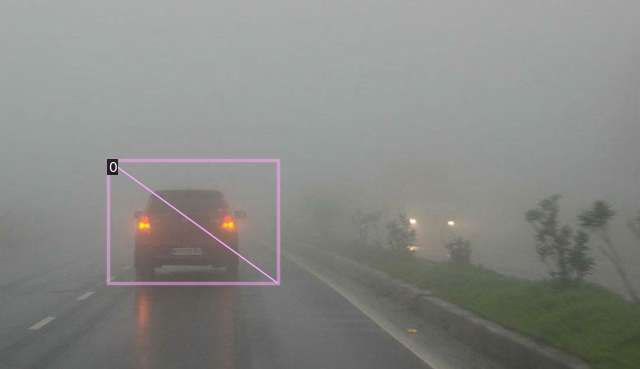

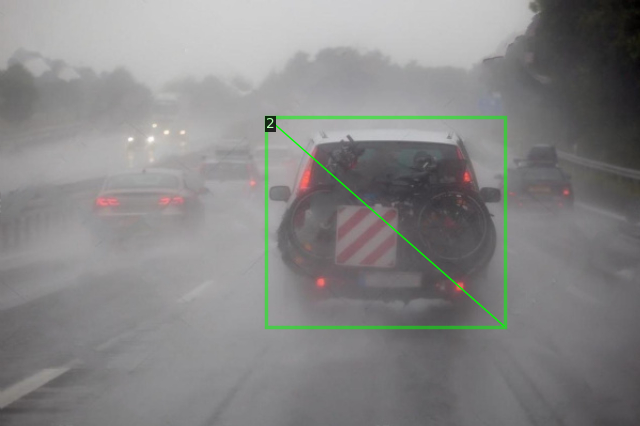

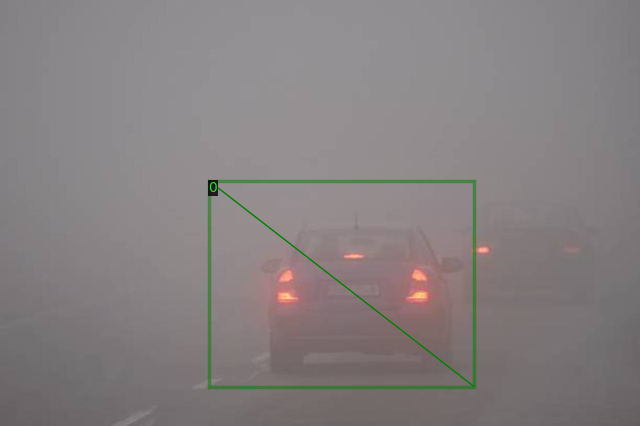

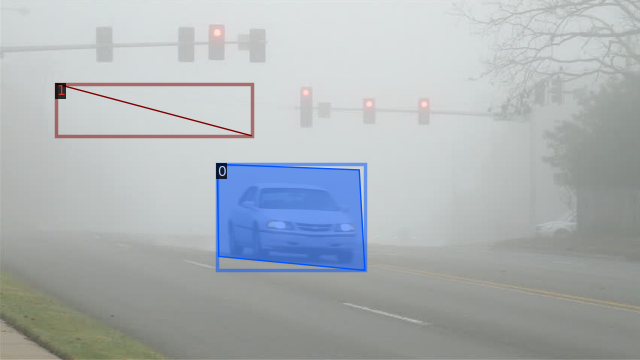

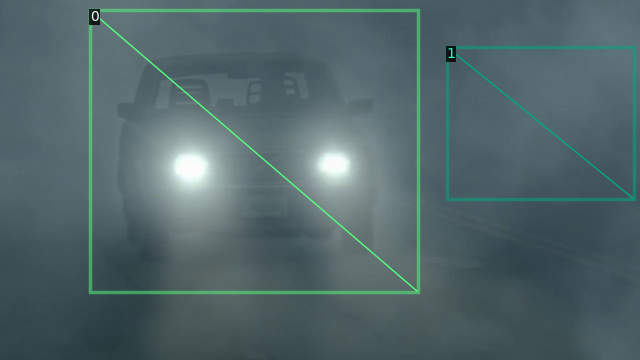

In [12]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow
import cv2
import random

# Register and load the dataset metadata (ensure it's registered first)
dawn_dataset_test1_metadata = MetadataCatalog.get("dawn_dataset_test1")

# Assuming dataset_dicts is already loaded with dataset details
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dawn_dataset_test1_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)

    # Use cv2_imshow for Google Colab to display the image
    cv2_imshow(out.get_image()[:, :, ::-1])


# **Train the Data**

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dawn_dataset_test1_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/03 14:03:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/03 14:03:28 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/03 14:03:39 d2.utils.events]:  eta: 0:07:48  iter: 19  total_loss: 1.659  loss_cls: 1.469  loss_box_reg: 0.1223  loss_rpn_cls: 0.0252  loss_rpn_loc: 0.01106    time: 0.4644  last_time: 0.5043  data_time: 0.0250  last_data_time: 0.0055   lr: 4.9953e-06  max_mem: 2637M
[10/03 14:03:52 d2.utils.events]:  eta: 0:07:42  iter: 39  total_loss: 1.523  loss_cls: 1.366  loss_box_reg: 0.1348  loss_rpn_cls: 0.02048  loss_rpn_loc: 0.01411    time: 0.4779  last_time: 0.4525  data_time: 0.0092  last_data_time: 0.0063   lr: 9.9902e-06  max_mem: 2638M
[10/03 14:04:01 d2.utils.events]:  eta: 0:07:27  iter: 59  total_loss: 1.284  loss_cls: 1.126  loss_box_reg: 0.1446  loss_rpn_cls: 0.01252  loss_rpn_loc: 0.01305    time: 0.4666  last_time: 0.5343  data_time: 0.0083  last_data_time: 0.0063   lr: 1.4985e-05  max_mem: 2638M
[10/03 14:04:11 d2.utils.events]:  eta: 0:07:21  iter: 79  total_loss: 1.019  loss_cls: 0.8267  loss_box_reg: 0.1332  loss_rpn_cls: 0.01689  loss_rpn_loc: 0.00962    time: 0.4707  la

In [14]:
torch.save(trainer.model.state_dict(), os.path.join(cfg.OUTPUT_DIR, "init_model.pth"))

In [16]:
cfg.OUTPUT_DIR

'./output'

In [15]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "init_model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("wind_turbine_test1_val", )
predictor = DefaultPredictor(cfg)

[10/03 14:18:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/init_model.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

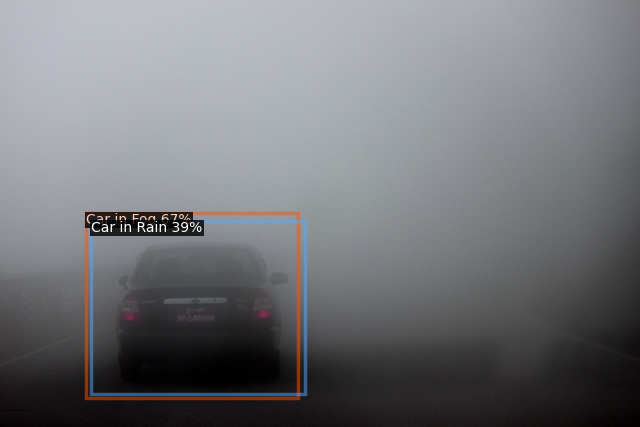

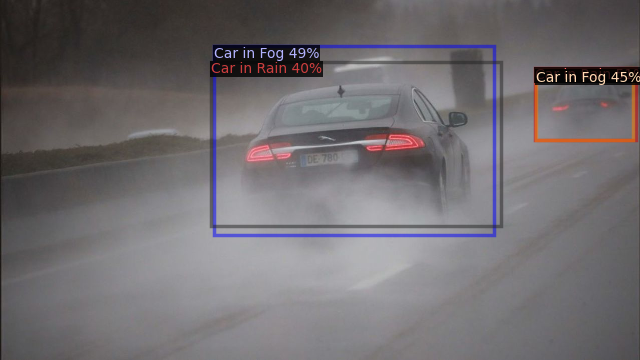

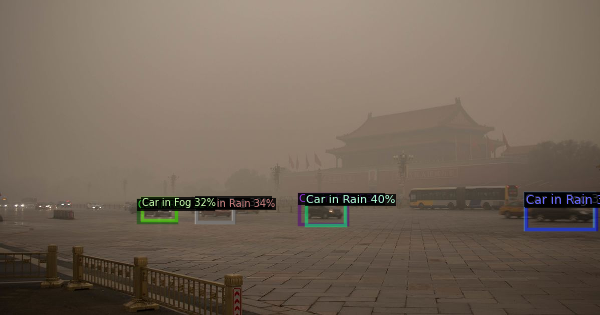

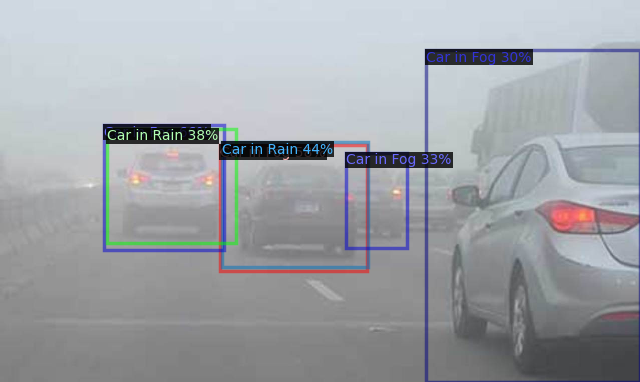

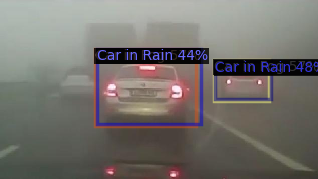

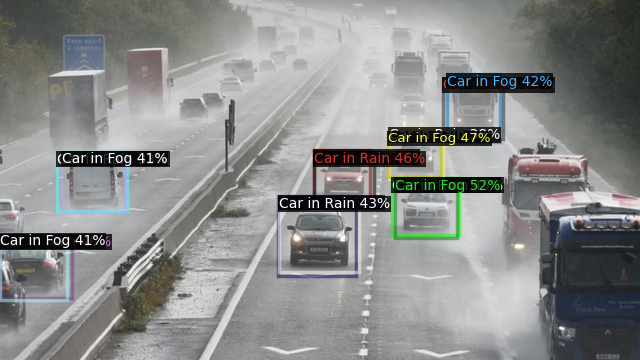

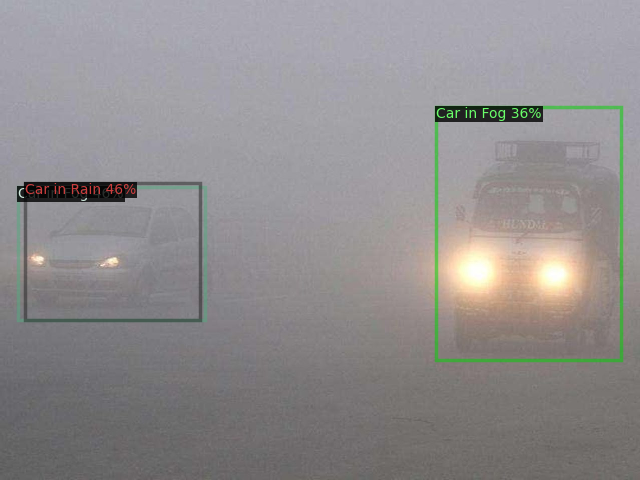

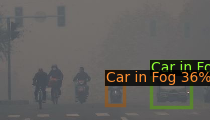

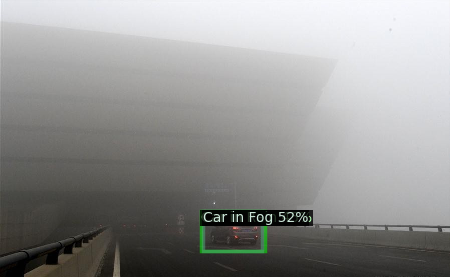

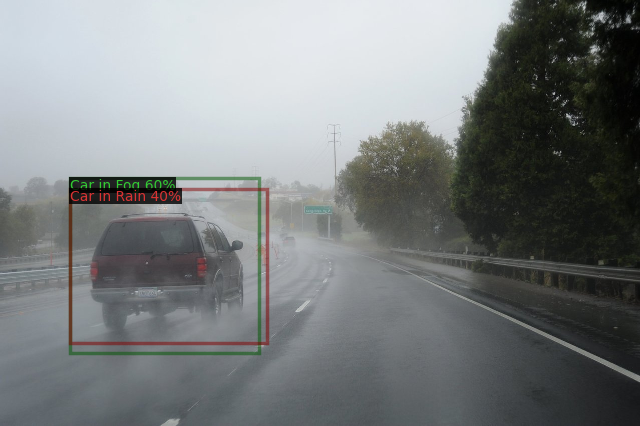

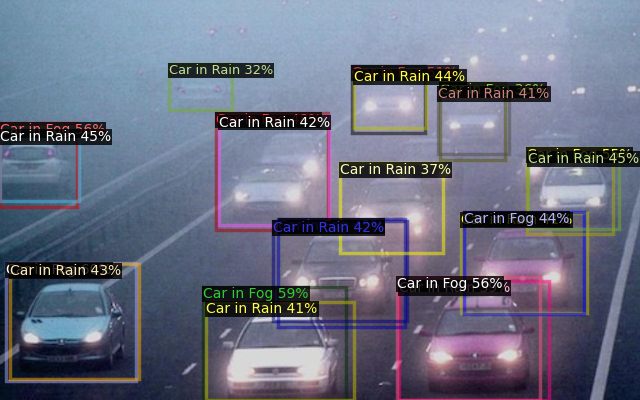

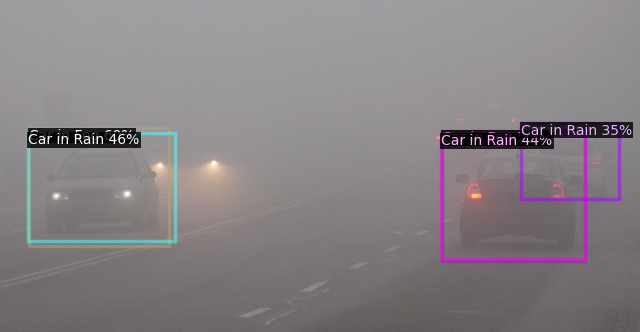

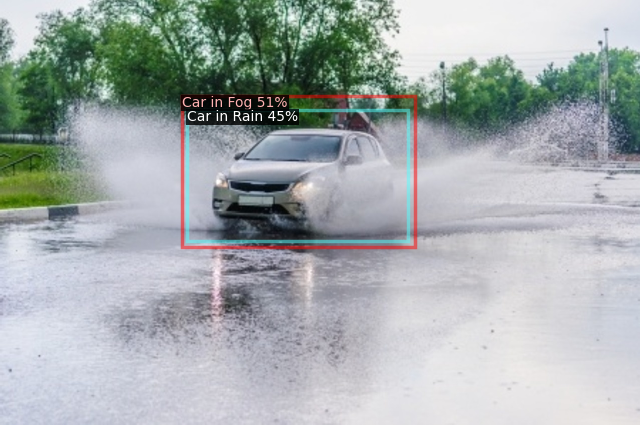

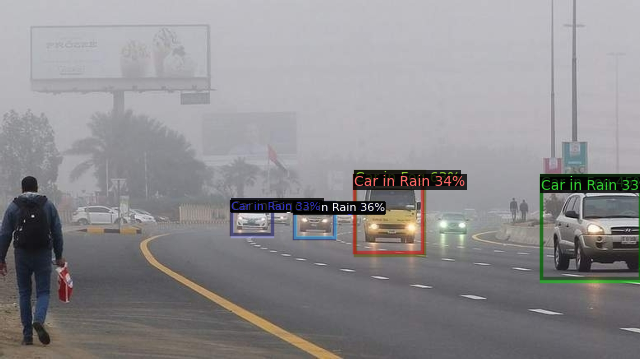

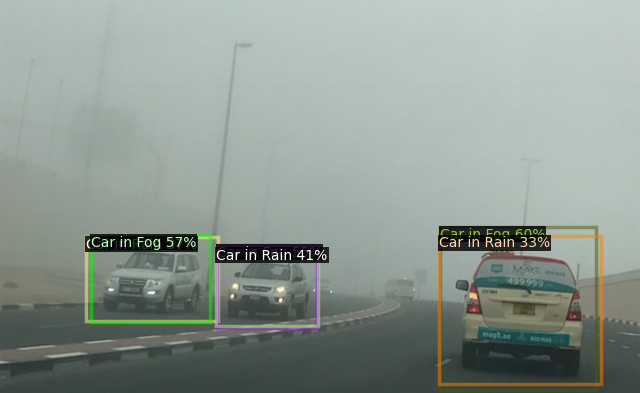

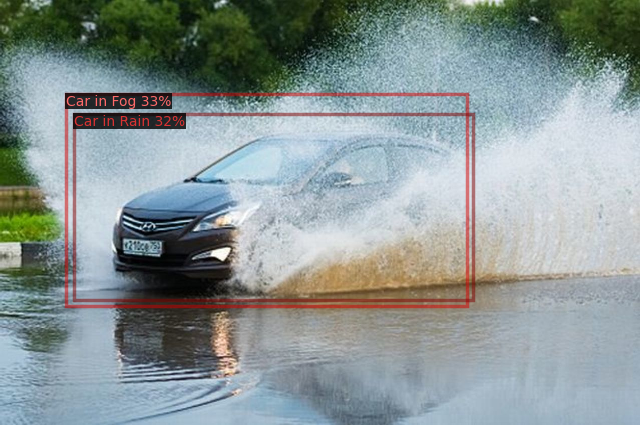

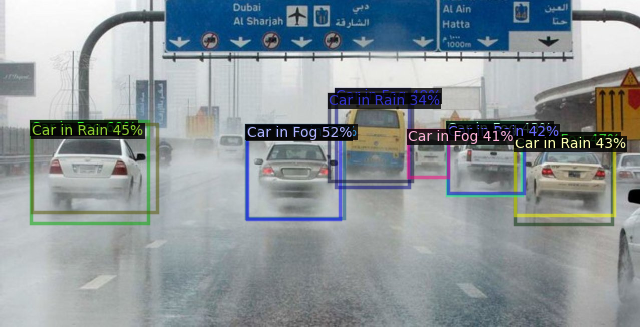

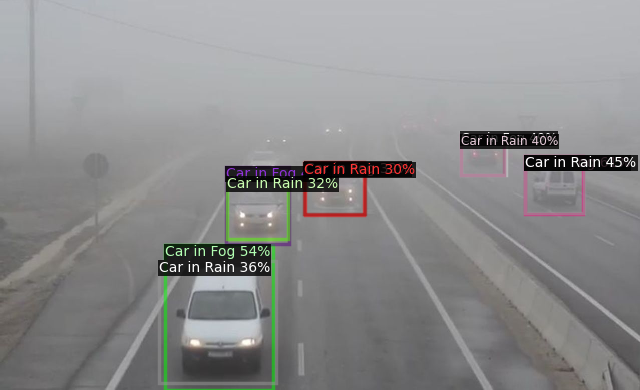

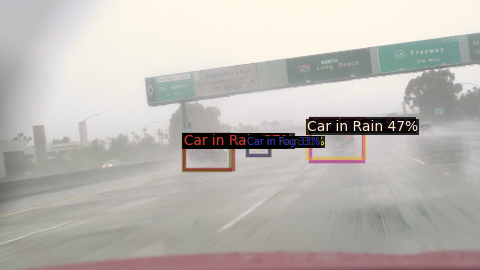

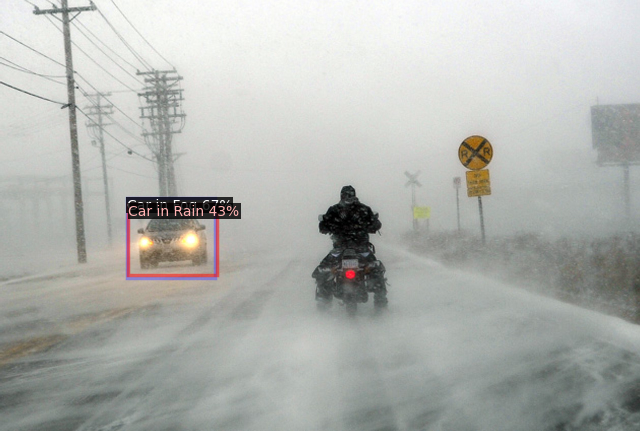

In [16]:
import matplotlib.pyplot as plt
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine.defaults import DefaultPredictor
from google.colab.patches import cv2_imshow


dataset_dicts = get_sign_dicts('/content/drive/MyDrive/DAWN Dataset/val')

# Ensure MetadataCatalog has the correct thing_classes
dawn_metadata = MetadataCatalog.get("dawn_dataset_test1_train")
if not hasattr(dawn_metadata, "thing_classes"):
  dawn_metadata.thing_classes = ["Car in Fog", "Fog", "Car in Rain"] # Update with actual class names

for d in random.sample(dataset_dicts, 20):
    im = cv2.imread(d["file_name"])
    if im is None:
      print(f"Failed to load image: {d['file_name']}")
      continue

    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=dawn_metadata, # Use metadata with thing_classes
                   scale=0.5,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

# **Converting Bounding Boxes into Polygons**

In [17]:
def get_sign_dicts(directory):
    classes = ["Car in Fog", "Fog", "Car in Rain"]
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["image_id"] = filename
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x-coordinates of the polygon
            py = [a[1] for a in anno['points']] # y-coordinates of the polygon
            poly = [(x, y) for x, y in zip(px, py)] # list of coordinate tuples
            if len(poly) == 4: # check if it's a bounding box
                x1, y1 = poly[0]
                x2, y2 = poly[2]
                poly = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)] # convert to polygon
            poly = [p for x in poly for p in x] # flatten the list of coordinates

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [18]:
def get_sign_dicts(directory):
    classes = ["Car in Fog", "Fog", "Car in Rain"]
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}

        filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["image_id"] = filename
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x-coordinates of the polygon
            py = [a[1] for a in anno['points']] # y-coordinates of the polygon
            poly = [(x, y) for x, y in zip(px, py)] # list of coordinate tuples
            # Check if the annotation has enough points and handle accordingly
            if len(poly) < 3:
                # If less than 3 points, skip the annotation or handle it differently (e.g., log a warning)
                print(f"Skipping annotation with less than 3 points: {poly}")
                continue
            poly = [p for x in poly for p in x] # flatten the list of coordinates

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# **Inferences from the Training**

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import DatasetCatalog, MetadataCatalog
import os

# Assuming your dataset loading function is named get_sign_dicts
def get_dawn_dataset_test1_dicts():
    train_dicts = get_sign_dicts('/content/drive/MyDrive/DAWN Dataset/train') # Load training data
    val_dicts = get_sign_dicts('/content/drive/MyDrive/DAWN Dataset/val') # Load validation data

    # Check if all files exist
    for d in train_dicts + val_dicts:
      if not os.path.exists(d["file_name"]):
        print(f"Missing file: {d['file_name']}")

    return train_dicts + val_dicts  # Combine train and val data

# Register the combined dataset
DatasetCatalog.register("dawn_dataset_test9", get_dawn_dataset_test1_dicts)
# Set thing_classes for dawn_dataset_test2
MetadataCatalog.get("dawn_dataset_test9").thing_classes = ["Car in Fog", "Fog", "Car in Rain"]

#Create the output directory if it doesn't exist
os.makedirs("./output", exist_ok=True)

evaluator = COCOEvaluator("dawn_dataset_test9", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "dawn_dataset_test9")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[10/03 14:19:34 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[10/03 14:19:34 d2.evaluation.coco_evaluation]: Trying to convert 'dawn_dataset_test9' to COCO format ...
[10/03 14:19:34 d2.data.datasets.coco]: Converting annotations of dataset 'dawn_dataset_test9' to COCO format ...)
Skipping annotation with less than 3 points: [(396.0747663551402, 462.36915887850466), (483.9252336448598, 546.4813084112149)]
Skipping annotation with less than 3 points: [(330.0990099009901, 399.76732673267327), (590.4950495049504, 581.9455445544555)]
Skipping annotation with less than 3 points: [(319.20792079207916, 373.03465346534654), (566.7326732673267, 577.9851485148515)]
Skipping annotation with less than 3 points: [(215.72815533980585, 620.9417475728155), (403.1067961165049, 776.2815533980582)]
Skipping annotation with less than 3 points: [(642.803738317757, 493.88785046728975), (827.8504672897196, 663.0467289719627)]
Skipping annotation with less t

In [23]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import DatasetCatalog, MetadataCatalog
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming your dataset loading function is named get_sign_dicts
def get_dawn_dataset_test1_dicts():
    train_dicts = get_sign_dicts('/content/drive/MyDrive/DAWN Dataset/train')  # Load training data
    val_dicts = get_sign_dicts('/content/drive/MyDrive/DAWN Dataset/val')  # Load validation data

    # Check if all files exist
    for d in train_dicts + val_dicts:
        if not os.path.exists(d["file_name"]):
            print(f"Missing file: {d['file_name']}")

    return train_dicts + val_dicts  # Combine train and val data

# Register the combined dataset
DatasetCatalog.register("dawn_dataset_test10", get_dawn_dataset_test1_dicts)
MetadataCatalog.get("dawn_dataset_test10").thing_classes = ["Car in Fog", "Fog", "Car in Rain"]

# Create the output directory if it doesn't exist
os.makedirs("./output", exist_ok=True)

# Run inference and evaluation
evaluator = COCOEvaluator("dawn_dataset_test10", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "dawn_dataset_test10")
results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Extract evaluation results for bbox
bbox_results = results["bbox"]


[10/03 14:27:19 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[10/03 14:27:19 d2.evaluation.coco_evaluation]: Trying to convert 'dawn_dataset_test10' to COCO format ...
[10/03 14:27:19 d2.data.datasets.coco]: Converting annotations of dataset 'dawn_dataset_test10' to COCO format ...)
Skipping annotation with less than 3 points: [(396.0747663551402, 462.36915887850466), (483.9252336448598, 546.4813084112149)]
Skipping annotation with less than 3 points: [(330.0990099009901, 399.76732673267327), (590.4950495049504, 581.9455445544555)]
Skipping annotation with less than 3 points: [(319.20792079207916, 373.03465346534654), (566.7326732673267, 577.9851485148515)]
Skipping annotation with less than 3 points: [(215.72815533980585, 620.9417475728155), (403.1067961165049, 776.2815533980582)]
Skipping annotation with less than 3 points: [(642.803738317757, 493.88785046728975), (827.8504672897196, 663.0467289719627)]
Skipping annotation with less

# **Prepare Data for Visualization**

In [25]:
# Convert bbox results to a Pandas DataFrame
data = {
    "Metric": ["AP", "AP50", "AP75", "AP-small", "AP-medium", "AP-large", "AR", "AR-small", "AR-medium", "AR-large"],
    "Score": [
        bbox_results["AP"],
        bbox_results["AP50"],
        bbox_results["AP75"],
        bbox_results.get("APs", 0),
        bbox_results.get("APm", 0),
        bbox_results.get("APl", 0),
        bbox_results.get("AR", 0), # Use .get() and provide a default value (0) if the key is missing
        bbox_results.get("ARs", 0),
        bbox_results.get("ARm", 0),
        bbox_results.get("ARl", 0)
    ]
}

df = pd.DataFrame(data)

**Bar Plot for AP and AR**

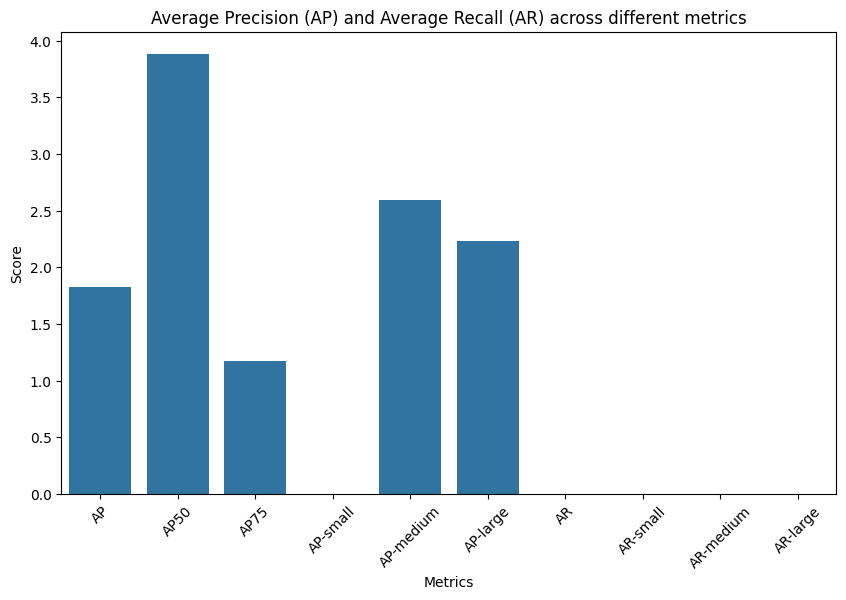

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", data=df)
plt.title("Average Precision (AP) and Average Recall (AR) across different metrics")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.xticks(rotation=45)
plt.show()

**Heatmap for AP and AR**

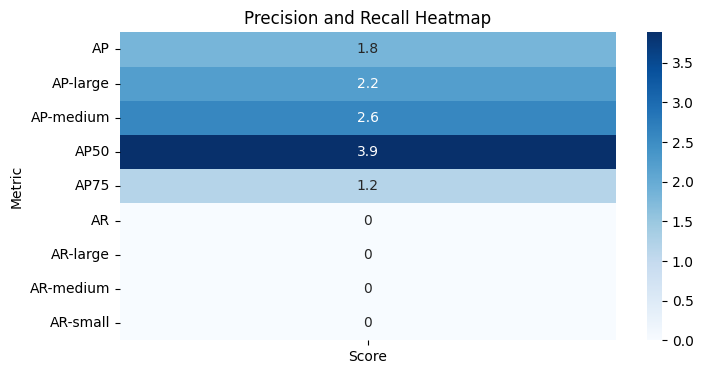

In [27]:
plt.figure(figsize=(8, 4))
score_matrix = df.pivot_table(index='Metric', values='Score')
sns.heatmap(score_matrix, annot=True, cmap="Blues")
plt.title("Precision and Recall Heatmap")
plt.show()

**Line Plots for AP and AR Trends**

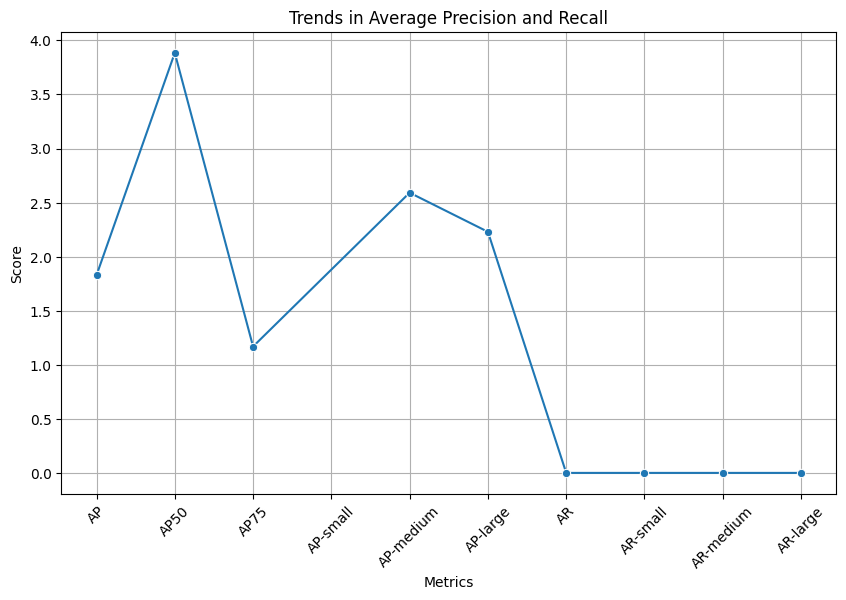

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="Metric", y="Score", data=df, marker='o')
plt.title("Trends in Average Precision and Recall")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Class-Wise Plot for AP and AR**

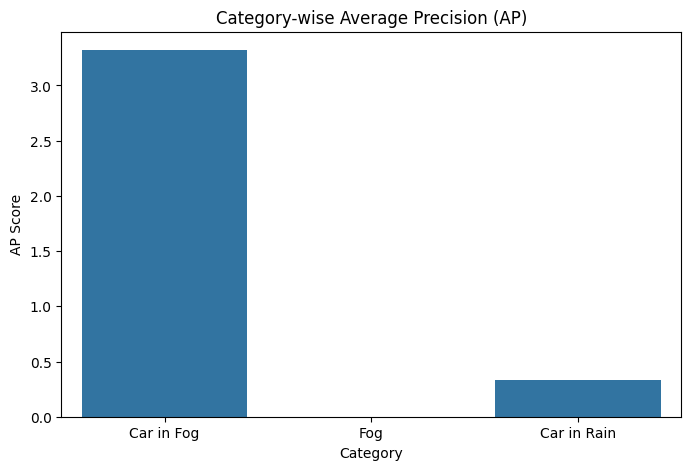

In [29]:
category_data = {
    "Category": ["Car in Fog", "Fog", "Car in Rain"],
    "AP": [
        bbox_results["AP-Car in Fog"],
        bbox_results.get("AP-Fog", 0),
        bbox_results["AP-Car in Rain"]
    ]
}

category_df = pd.DataFrame(category_data)

# Bar plot for category-wise AP
plt.figure(figsize=(8, 5))
sns.barplot(x="Category", y="AP", data=category_df)
plt.title("Category-wise Average Precision (AP)")
plt.ylabel("AP Score")
plt.xlabel("Category")
plt.show()